In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import glob
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


DATASET

In [11]:
class genderDataset(Dataset):
    def __init__(self, root_dir, is_train=True, image_size=224):
        self.root_dir = root_dir
        self.image_size = image_size
        self.is_train = is_train

        if not os.path.exists(self.root_dir):
            raise RuntimeError(f"Dataset not found at {self.root_dir}.")

        if self.is_train:
            self.transform = transforms.Compose([
                transforms.Resize((self.image_size, self.image_size)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((self.image_size, self.image_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        self.data = []
        self.labels = []
        for label, class_name in tqdm(enumerate(['pria','wanita'])):
            class_dir = os.path.join(self.root_dir, class_name)
            image_paths = glob.glob(os.path.join(class_dir, '*.jpg'))
            self.data.extend(image_paths)
            self.labels.extend([label] * len(image_paths))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        return image, label

TRAIN

2it [00:00, 147.65it/s]
2it [00:00, 1065.22it/s]
Epoch 1/10 [Testing]: 100%|██████████| 6/6 [00:15<00:00,  2.55s/it]


Epoch 1: Train Loss=0.8254, Test Loss=0.5922, Acc=0.6766


Epoch 2/10 [Testing]: 100%|██████████| 6/6 [00:15<00:00,  2.56s/it]


Epoch 2: Train Loss=0.3718, Test Loss=0.2869, Acc=0.8802


Epoch 3/10 [Testing]: 100%|██████████| 6/6 [00:19<00:00,  3.26s/it]


Epoch 3: Train Loss=0.1421, Test Loss=0.2398, Acc=0.8743


Epoch 4/10 [Testing]: 100%|██████████| 6/6 [00:14<00:00,  2.49s/it]


Epoch 4: Train Loss=0.0880, Test Loss=0.2289, Acc=0.8623


Epoch 5/10 [Testing]: 100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


Epoch 5: Train Loss=0.0692, Test Loss=0.1869, Acc=0.9042


Epoch 6/10 [Testing]: 100%|██████████| 6/6 [00:14<00:00,  2.49s/it]


Epoch 6: Train Loss=0.0340, Test Loss=0.2158, Acc=0.8982


Epoch 7/10 [Testing]: 100%|██████████| 6/6 [00:14<00:00,  2.50s/it]


Epoch 7: Train Loss=0.0319, Test Loss=0.2303, Acc=0.9042


Epoch 8/10 [Testing]: 100%|██████████| 6/6 [00:15<00:00,  2.60s/it]


Epoch 8: Train Loss=0.0184, Test Loss=0.3003, Acc=0.8743
Early stopping triggered!


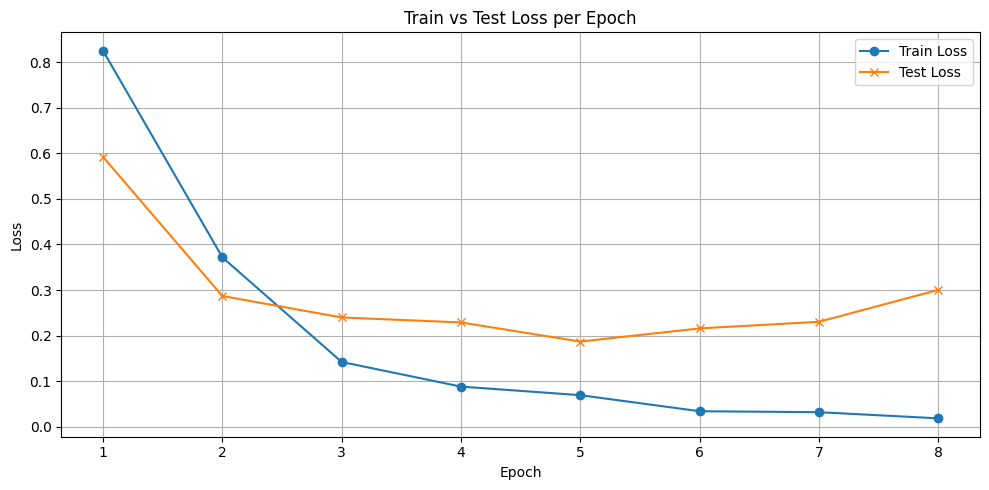

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32

train_dataset = genderDataset(root_dir='data/genderDataset/train', is_train=True)
test_dataset  = genderDataset(root_dir='data/genderDataset/test', is_train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_features, 2)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epoch = 10
patience = 3
trigger_times = 0
best_loss = float('inf')

train_losses = []
test_losses = []

for epoch in range(num_epoch):
    model.train()
    train_loss = 0
    for data, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epoch} [Training]"):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epoch} [Testing]"):
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * data.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_train_loss = train_loss / len(train_dataset)
    avg_test_loss = test_loss / len(test_dataset)
    acc = correct / total

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Test Loss={avg_test_loss:.4f}, Acc={acc:.4f}")

    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered!")
            break

epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Simpan checkpoint
torch.save({
    'epoch': len(train_losses),
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses,
    'test_loss': test_losses,
}, 'output/gender_checkpoint.pth')

prediksi gender

Prediction: wanita


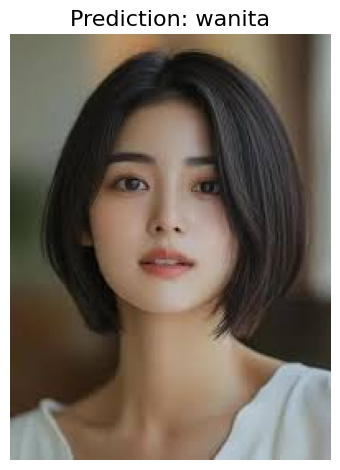

In [ ]:
def load_model(weight_path, num_classes, device):
    model = resnet18(weights=None)
    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(model.fc.in_features, num_classes)
    )
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

# model mem-prediksi
def predict_image(image_path, model, device, class_names):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        _, pred = torch.max(outputs, 1)
    predicted_class = class_names[pred.item()]
    return predicted_class, image

# input
if __name__ == '__main__':
    class_names = ['pria', 'wanita']
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = load_model('output/best_model.pth', num_classes=len(class_names), device=device)
    img_path = 'data/images.jpeg'
    predicted_label, image = predict_image(img_path, model, device, class_names)
    print(f"Prediction: {predicted_label}")
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label}", fontsize=16)
    plt.tight_layout()
    plt.show()

confusion matrix

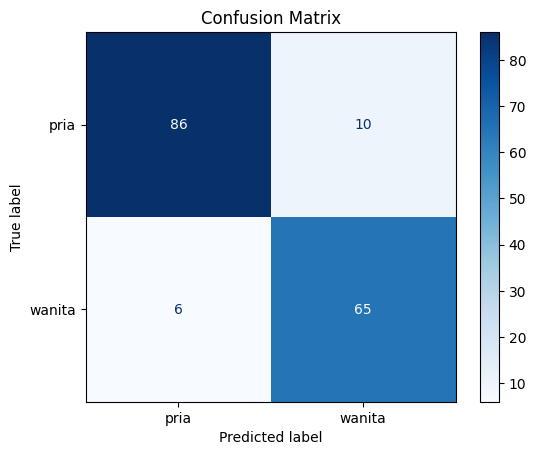

In [14]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# matrix dibuat
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['pria', 'wanita'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()


In [15]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
print(f"Akurasi total model: {accuracy * 100:.2f}%")

Akurasi total model: 90.42%
